# DistilBERT Fine-Tuning 


Notebook code is based on https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=BJR6t_gCQe_x
by Chris McCormick and Nick Ryan

We have adapted it for our use case, namely using a distillated version of BERT with weight decay

Original notebook was demonstrated in these videos:
- https://www.youtube.com/watch?v=x66kkDnbzi4&feature=youtu.be
- https://www.youtube.com/watch?v=Hnvb9b7a_Ps&feature=youtu.be

In [1]:
%run imports.py

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [6]:
df = pd.read_csv("cleaned-train-balanced-sarcasm-2.csv")[['label', 'cleaned comment', 'comment']].dropna().sample(5000)

In [7]:
df.head()

label                                    cleaned comment  \
228726      0        agree with you but it the world we live in    
844588      1  FOX news discussing the issues america really ...   
870581      0    if we can see them then there no problem right    
701537      0          you don think it be like it is but it do    
653405      0  even more proof why the commentary community a...   

                                                  comment  
228726   I agree with you, but it's the world we live in.  
844588  FOX news discussing the issues America really ...  
870581  If we can't see them, then there's no problem ...  
701537        You don't think it be like it is, but it do  
653405  Even more proof why the Commentary Community a...

In [30]:
df.loc[df.label == 0].sample(5)[['cleaned comment', 'label']]

cleaned comment  label
892545           has the trade window closed for mallett       0
314911                           yay enchantments galore       0
957176  seems like you should be apologizing to the pe...      0
247716                                         nice shot       0
494408  then why don you start link about that rather ...      0

In [45]:
# Get the lists of sentences and their labels.
def max_len_filter(x):
    if len(x) < 512:
        return x
    else:
        return np.nan

max_len_sentences = df.loc[df['cleaned comment'].str.len() < 512]

sentences = max_len_sentences['cleaned comment'].values
labels = max_len_sentences.label.values

num_removed = len(df) - len(sentences)

print("Number of sentences > 512 tokens removed from {} sentences: {}".format(len(df), num_removed))

Number of sentences > 512 tokens removed from 5000 sentences: 1


In [46]:
from transformers import DistilBertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [47]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  agree with you but it the world we live in 
Tokenized:  ['agree', 'with', 'you', 'but', 'it', 'the', 'world', 'we', 'live', 'in']
Token IDs:  [5993, 2007, 2017, 2021, 2009, 1996, 2088, 2057, 2444, 1999]


In [48]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  agree with you but it the world we live in 
Token IDs: [101, 5993, 2007, 2017, 2021, 2009, 1996, 2088, 2057, 2444, 1999, 102]


In [49]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  98


In [50]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = max([len(sen) for sen in input_ids]) + 2

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 100 values...

Padding token: "[PAD]", ID: 0

Done.


In [51]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [52]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [53]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).type(torch.LongTensor)
validation_inputs = torch.tensor(validation_inputs).type(torch.LongTensor)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [54]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32. Our computers can handle 8 at best though.

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [55]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2 # The number of output labels--2 for binary classification.

)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [56]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The DistilBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[4:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The DistilBERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight      

In [57]:
# implement weight decay for bias parameters
no_decay = ["bias", "LayerNorm.weight"]

optimizer_grouped_parameters = [
    {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}
    ]
    
optimizer = AdamW(optimizer_grouped_parameters, 
                  lr=2e-5, 
                  eps=1e-8)

In [58]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 6

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [59]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [60]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [61]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:06.
  Batch    80  of    563.    Elapsed: 0:00:12.
  Batch   120  of    563.    Elapsed: 0:00:17.
  Batch   160  of    563.    Elapsed: 0:00:23.
  Batch   200  of    563.    Elapsed: 0:00:29.
  Batch   240  of    563.    Elapsed: 0:00:35.
  Batch   280  of    563.    Elapsed: 0:00:41.
  Batch   320  of    563.    Elapsed: 0:00:46.
  Batch   360  of    563.    Elapsed: 0:00:52.
  Batch   400  of    563.    Elapsed: 0:00:58.
  Batch   440  of    563.    Elapsed: 0:01:04.
  Batch   480  of    563.    Elapsed: 0:01:10.
  Batch   520  of    563.    Elapsed: 0:01:15.
  Batch   560  of    563.    Elapsed: 0:01:21.

  Average training loss: 0.66
  Training epoch took: 0:01:21

Running Validation...
  Accuracy: 0.62
  Validation took: 0:00:02

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:06.
  Batch    80  of    563.    Elapsed: 0:00:12.
  Batch   120  of    563.    Elap

Let's take a look at our training loss over all batches:

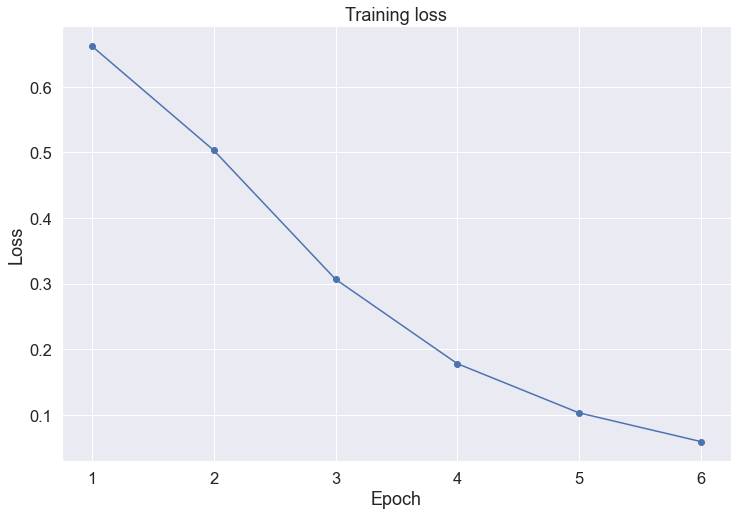

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(np.arange(1,7))
plt.show()

fig.savefig("plots/distilbert_5k_training_50.png", dpi=250, bbox_inches='tight')

In [24]:
final_loss = [0.0658254051703124,
 0.0727571986957253,
 0.06969812353486475,
 0.061764052885118874,
 0.06154042372203517,
 0.0863746557537292,
 0.08207794689460078]

In [75]:
final_loss.append(avg_train_loss)
final_loss

[0.0658254051703124,
 0.0727571986957253,
 0.06969812353486475,
 0.061764052885118874,
 0.06154042372203517,
 0.0863746557537292,
 0.08207794689460078,
 0.04981541579775512,
 0.06531088074891243,
 0.05951331071325015]

In [ ]:
average_batch_time = [5, 5, 5, 5, 5]

In [76]:
reverse_loss = final_loss[::-1]
print(reverse_loss)

[0.05951331071325015, 0.06531088074891243, 0.04981541579775512, 0.08207794689460078, 0.0863746557537292, 0.06154042372203517, 0.061764052885118874, 0.06969812353486475, 0.0727571986957253, 0.0658254051703124]


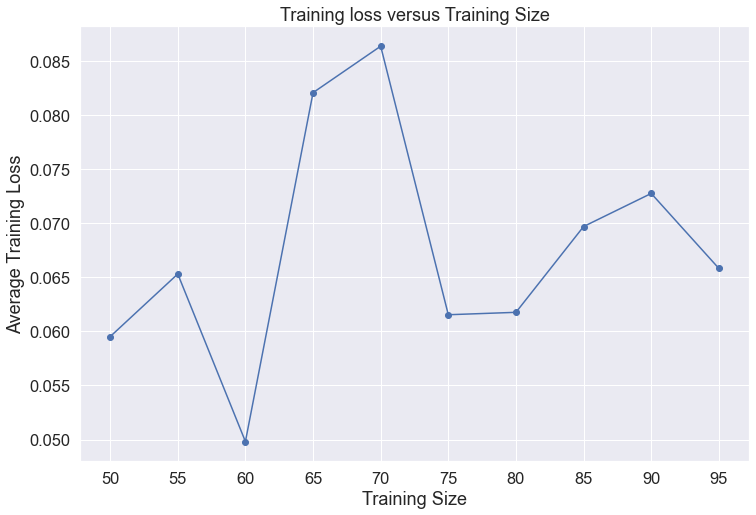

In [78]:
fig, ax = plt.subplots(figsize=(12,8))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(reverse_loss, 'b-o')

# Label the plot.
plt.title("Training loss versus Training Size")

plt.xlabel("Training Size")
plt.ylabel("Average Training Loss")
ax.set_xticks(np.arange(0, 10))
ax.set_xticklabels(np.arange(50, 100, 5))
plt.show()

fig.savefig("plots/distilbert_5k_training_completed.png", dpi=250, bbox_inches='tight')

In [84]:
test_sentences = df_test.comment.values
test_labels = df_test.label.values

In [85]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in test_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids).type(torch.LongTensor)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [86]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [87]:
print('Positive samples: %d of %d (%.2f%%)' % (df_test.label.sum(), len(df_test.label), (df_test.label.sum() / len(df_test.label) * 100.0)))

Positive samples: 4998 of 10000 (49.98%)


In [88]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                

    matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 


In [89]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.561


In [123]:
from sklearn.metrics import classification_report, accuracy_score

report = classification_report(flat_true_labels, flat_predictions, target_names=['ns', 's'], output_dict=True)
acc = accuracy_score(flat_true_labels, flat_predictions)
print(results)
print(acc)

report_df = pd.DataFrame(report).transpose()

              precision    recall  f1-score   support

          ns       0.78      0.78      0.78      5002
           s       0.78      0.78      0.78      4998

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

0.7805


In [136]:
results = pd.DataFrame({'Score':[mcc, acc]}, index=['MCC', 'Accuracy'])

In [138]:
report_df.to_csv("results/distilbert_200k_clf_report")
results.to_csv("results/distilbert_200k_results")

hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.)

In [90]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'saved_models/DistilBERT_base_200ktrained'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to saved_models/DistilBERT_base_200ktrained


('saved_models/DistilBERT_base_200ktrained\\vocab.txt',
 'saved_models/DistilBERT_base_200ktrained\\special_tokens_map.json',
 'saved_models/DistilBERT_base_200ktrained\\added_tokens.json')